# Problem 3

## Problem description

This problem was posted originally [in this Data Science job post](https://www.glassdoor.nl/Vacature/amsterdam-data-scientist-optiver-vacatures-SRCH_IL.0,9_IC3064478_KO10,24_KE25,32.htm). I reproduce it below for the sake of completness.

Calvin has to cross several signals when he walks from his home to school. Each of these signals operate independently. They alternate every 80 seconds between green light and red light. At each signal, there is a counter display that tells him how long it will be before the current signal changes. Calvin has a magic wand which lets him turn a signal from red to green instantaneously. However, this wand comes with limited battery life, so he can use it only for a specified number of times.
### Cases
1. If the total number of signals is 2 and Calvin can use his magic wand only once, then what is the expected waiting time at the signals when Calvin optimally walks from his home to school?
2. What if the number of signals is 3 and Calvin can use his magic wand only once?
3. Can you write a code that takes as inputs the number of signals and the number of times Calvin can use his magic wand, and outputs the expected waiting time?

## Problem solution
Notation

* $N$ is the total number of signals.
* $W$ is the total number of times that the magic wand can be used. 
* $R_n$ denotes the binary event that the $n$-th signal is red when Calvin arrives, with $n=1,\dots,N$. 
* $X_n$ is the remaining time displayed at the counter of the $n$-th signal, with $n=1,\dots,N$.
* $T_n$ is the waiting time at the $n$-th signal, with $n=1,\dots,N$.
* $T = \sum_1^N T_n$ is the total waiting time.

We assume that as long as the corresponding signal is green, Calvin can cross regardless of how much time is left for the green light.

### Case 0: $N$ signals and $W=0$ usage of the wand 
This case is not requested but it is the baseline to evaluate cases 1 and 2 below. There are two situations which can occurred with probability 0.5:
1. If $R_1=0$, i.e. the first signal is green when Calvin arrives, then he does not wait i.e. $T_1 = 0$.

2. If $R_1=1$, i.e. the first signal is red when Calvin arrives, then he has to wait. This waiting time can be modelled with a uniform distribution unif(0,80), which has an expected value of 40. 
 
Therefore:

$$ E(T) = E(T_1) + \dots + E(T_N) = N \cdot E(T_1)$$
Situations 1 and 2, imply that
$$ E(T) = N \cdot [E(T_1|R_1=0)\cdot P(R_1=0) + E(T_1|R_1=1)\cdot P(R_1=1)]$$
Finally,
$$ E(T) = N \cdot \left[0\cdot \frac12 + 40 \cdot \frac12 \right] = 20\cdot N \text{ seconds.}$$

### Case 1: $N=2$ signals and $W=1$ usage of the wand 
There are the following 2 situations, both occuring with probability 0.5:

1. If $R_1=0$, i.e. the first signal is green when Calvin arrives, then he neither has to wait nor use the wand, and he can spare its usage for the second signal in case that it is red. In this situation both $T_1 = 0$ and $T_2 = 0$.

2. If $R_1=1$, i.e. the first signal is red when Calvin arrives, then he should use the magic wand depending on $X_1$, the remaining time displayed at the first counter. We propose Strategy $(M)$, which consits of:

    a. If $X_1<=M$, then Calvin should wait until the first signal turns green and use the magic wand at the second signal if this one is red. In this situation, $T_1\sim$ unif(0,$M$) and $T_2 = 0$.
   
    b. If $X_1>M$, then Calvin should use the magic wand to turn the first signal into green and continue to the second signal, where he will have to wait in case that it is red since he cannot longer use the wand. In this situation, $T_1 = 0$ and $T_2\sim$ unif(0,80) or $T_2=0$, both  with probability 0.5.
    
##### Simulation
If the second signal is red, then the waiting time can be modelled by a uniform distribution unif(0,80) with expected value 40. This situation only occurs with probability 0.5, thus the expected waiting time is 20 seconds. Intuitively, Calvin should use the wand at the first signal if the waiting time is larger than 20 and wait if the waiting time is less than 20, in other words $M=20$. 

##### How many simulations?
We need to determine how many simulations are needed to have a good estimation of the expected time. Let $\mu$ and $\sigma^2$ denote the mean and variance of $T$. By the Central Limit Theorem, we know that if $T^i$ are i.id. copies of $T$, with $i = 1\dots,m$, then the average $S = (\sum_{i=1}^m T^i)/m$ approaches a normal distribution with mean $\mu$ and standard deviation $\sigma/\sqrt{m}$. Thus with probability 0.95, the error between the mean $\mu$ and the observed sample mean $S$ is bounded by

$$|\mu - S| \le 1.96\frac{\sigma}{\sqrt{m}}.$$

If we allow an error of $|\mu - S|=0.1$ and $c^2$ is an upper bound of the variance $\sigma^2$, i.e. $\sigma^2 < c^2$, then 
$$0.1 = 1.96\frac{\sigma}{\sqrt{m}} \le 1.96\frac{c}{\sqrt{m}}\, \implies \, m = \left(1.96\frac{c}{0.1}\right)^2 = 19.6^2c^2.$$

So we will find an upper bound for $\sigma^2$, notice that
$$\sigma^2 = \text{Var}(T) = E(T^2) - E(T)^2 \le E(T^2) \le (N80)^2.$$
The second inequality is due to the fact that at each of the $N$ signals, the waiting time is at most 80. Then for $N = 2$ we get $\sigma \le 160$ and thus $n = 19.6^2160^2 = 9834496$


##### Mathematically
If $E_M$ denotes the expectation when using treshold $M$ for the strategy, then situation 1 and 2 imply 
$$E_M(T) = E_M(T \,|\, R_1 = 0) \cdot  P(R_1 = 0) + E_M(T \,|\, R_1 = 1) \cdot  P(R_1 = 1) = 0 \cdot  \frac{1}{2} + E_M(T \,|\, R_1 = 1) \cdot  \frac{1}{2}$$

Thus we only have to compute the second term in the last sum. Depending on the counter value we have that
$$ E_M(T \,|\, R_1 = 1) = E_M(T \,|\, R_1 = 1, X_1<=M) \cdot P(R_1 = 1, X_1<=M) + E_M(T \,|\, R_1 = 1, X_1>M) \cdot P(R_1 = 1, X_1>M)$$

Substituting all values yields,
$$ E_M(T \,|\, R_1 = 1)  = \frac{M}{2}\cdot\frac{M}{80} + \left(\frac{80}{2}\cdot\frac12 + 0\cdot\frac12 \right)\cdot\frac{80-M}{80} = \frac{M^2}{160} -\frac{M}{4} + 20.
$$
                   
Replacing this quantity in the original equation, we get
$$E_M(T) = \left(\frac{M^2}{160} -\frac{M}{4} + 20\right) \cdot \frac{1}{2},$$

a parabola that opens upwards, so its critical point gives the minimum value. Taking the derivative of $E_M(T)$ with respect to $M$ and equating to 0 yields
$$\frac{d}{dM}E_M(T) = \left(\frac{2M}{160} -\frac{1}{4}\right) \cdot \frac{1}{2} = 0 \implies M = 20.$$

The minimum expected waiting time is obtained after evaluating $E_{M}(T)$ at $M=20$,
$$E_{20}(T) = \left(\frac{20^2}{160} -\frac{20}{4} + 20\right) \cdot \frac{1}{2} 
= \left(\frac{400}{160} + 15\right) \cdot \frac{1}{2} = (17.5) \cdot \frac{1}{2}  = 8.75 \text{ seconds}.$$

##### Note
For $N=2$ signals and $W=0$, i.e. there is no magic wand, $E(T) = 40$ seconds as computed in case 0. Now, with $W=1$ and the application of the optimal Strategy (20), the waiting time has been reduced to 8.75 seconds.

### Case 2: $N=3$ signals and $W=1$ usage of the wand 

## Libraries

In [7]:
library(ggplot2)
library(dplyr)

## Functions for calculations

In [3]:
# Compute_wait_time: Computes recursively waiting time (seconds) of signals.
# INPUT:
#   N = (integer) total number of signals.
#   W = (integer) total number of times that the magic wand can be used.
#   period_length = (float) time period for duration of signal green and red.
#   prob_red = (float) probability that signal is red, assume prob_green = 1 - prob_red
#   M = (float) treshold for Strategy(M), range [0, period_length] 
# OUTPUT:
#   (float) sum of waiting times of signals (seconds).
Compute_wait_time = function(
    N,
    W,
    period_length,
    prob_red,
    M){ 
  
    # There are as many wand usages as signals, then Calvin can use the wand and he does not wait at all.
    if(W >= N){ 
        return(0)

    # There is no wand usage, then Calvin has to wait for all the remaining signals that are RED.
    }else if(W == 0){
        red_signals = runif(n = N, min = 0, max = period_length)
        wait_times = sample(x = c(1, 0), size = N, replace = TRUE, prob = c(prob_red, 1 - prob_red))
        # return sum of waiting times for red lights
        return(sum(red_signals * wait_times))

    }else{
        # Determine whether signal is green (=1) or red(=0),
        # with probabilities prob_green = 1 - prob_red and pro_red, respectively.
        is_green = sample(x = c(1, 0), size = 1, replace = TRUE, prob = c(1 - prob_red, prob_red))

        if (is_green){
            # Situation 1: If signal is green, then its waiting time is 0 so Calvin continues to next signals.
            return(Compute_wait_time(N - 1, W, period_length, prob_red, M))   
        }else{            
            # Situation 2: Apply Strategy(M)
            # Generate time counter at traffic light
            X = runif(n = 1, min = 0, max = period_length)
            
            # Situation 2.a: If waiting time is low, wait for signal to turn green and 
            # spare wand usage to next signals
            if (X <= M) return(X + Compute_wait_time(N - 1, W, period_length, prob_red, M)) 
            # Situation 2.b: If waiting time si high, use wand to cross immediately and 
            # continue to next signal with one less wand usage.
            else return(Compute_wait_time(N - 1, W - 1, period_length, prob_red, M))               
        }  
    } 
}
      
# Compute_mean_wait_time: Computes MEAN waiting time of signals(seconds).
# INPUT:
#   num_experiments = (integer) total number of experiments used to compute mean.
#   N = (integer) total number of signals.
#   W = (integer) total number of times that the magic wand can be used.
#   period_length = (float) time period for duration of signal green and red ().
#   prob_red = (float) probability that signal is red
#   M = (float) treshold for Strategy(M), range [0, period_length]
# OUTPUT:
#   (float) mean of sum of waiting times of signals (seconds).
Compute_mean_wait_time = function(
    num_experiments,
    N,
    W,
    period_length,
    prob_red,
    M){ 
    
    waiting_times = sapply(1:num_experiments, function(i){
      Compute_wait_time(
          N, 
          W,
          period_length,
          prob_red,
          M)
    })    
    return(mean(waiting_times))
}

# Plot_solution: Plots Simulated and exact solution for a set of tresholds M.
# INPUT:
#  tresholds = (vector floats) treholds M used in Strategy(M).
#  solution_sim = (vector floats) simulated waiting time for corresponding treshold M.
#  solution_exact = (vectors floats) exact waiting time for corresponding treshold M.
#  title = (string) title of plot.
# OUTPUT:
#   plot depicting both simulated (blue) and exact (red) waiting times for corresponding tresholds M.     
Plot_solution = function(
    tresholds,
    solution_sim,
    solution_exact,
    title){
    
    # Prepare data for display
    df = data.frame(tresholds = tresholds, 
                    simulation = solution_sim, 
                    exact = solution_exact)
    # Plot
    ggplot(data = df, aes(x = tresholds)) + 
        geom_line(aes(y = simulation, color = 'Simulation')) + 
        geom_line(aes(y = exact, color = 'Exact')) + 
        scale_color_manual('Solution type: ',
                           breaks = c('Simulation', 'Exact'),
                           values = c('Simulation'='blue', 'Exact'='red')) + 
        ylab('Mean waiting time (s)') +
        xlab('Treshold M (s)') + 
        ggtitle(title) +
        theme(legend.position = 'top')
}

##### Exact solutions ----
# Exact0: Given total number of signals N, returns (exact) expected waiting time as in case 0.
# INPUT:
#   N = (integer) total number of signals.
# OUTPUT:
#   (float) mean of sum of waiting times of N signals (seconds).
Exact0 = function(N){
    return(20*N)
}


# Exact1: Given a treshold M, returns (exact) expected waiting time as in case 1.
# INPUT:
#   M = (float) treshold for Stratgy (M) as described in case 1.
# OUTPUT:
#   (float) exact expected waiting time (seconds) as described in case 1.
Exact1 = function(M){
    return((M^2/160 - M/4 + 20)/2)
}

## Calculations & results

##### Case 0

In [16]:
tresholds_M = seq(from = 0, to = 80, by = 0.5)
num_simulations = 10000
N = 2
W = 0

waiting_times_case0 = sapply(tresholds_M, function(M){
        Compute_mean_wait_time(
            num_experiments = num_simulations,
            N = N,
            W = W,
            period_length = 80,
            prob_red = 0.5,
            M = M)
})

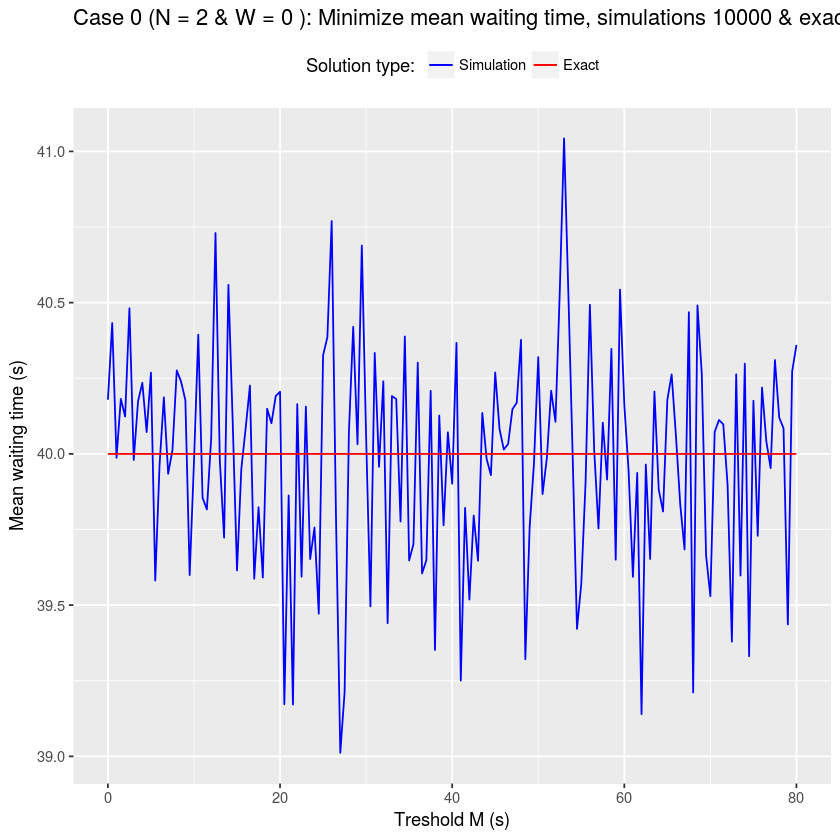

In [17]:
Plot_solution(
    tresholds = tresholds_M,
    solution_sim = waiting_times_case0,
    solution_exact = rep(Exact0(2), length(tresholds_M)),
    title = paste('Case 0 (N =', N, '& W =', W, '): Minimize mean waiting time, simulations', 
                  num_simulations,
                  '& exact solution'))

##### Case1

In [9]:
# Compute mean waiting time for different tresholds M for a high number of simulations
tresholds_M = seq(from = 0, to = 80, by = 0.5)
num_simulations = 124468
  
waiting_times_case1 = sapply(tresholds_M, function(M){
        Compute_mean_wait_time(
            num_experiments = num_simulations,
            N = 2,
            W = 1,
            period_length = 80,
            prob_red = 0.5,
            M = M)
})

In [ ]:
Plot_solution(
    tresholds = tresholds_M,
    solution_sim = waiting_times_case1,
    solution_exact = Exact1(tresholds_M),
    title = paste('Case 1: Minimize mean waiting time, simulations', 
                  num_simulations,
                  '& exact solution'))
